<font size="5"> Alberta Wildfire Data Analysis and Model Comparison </font>

**Overview**


The goal of this analysis is to compare the accuracy of multiple binary classification algorithms on the Alberta Wildfire
dataset. I will compare traditional Logistic Regression, K Nearest Neighbors, Random Forest and a Support Vector
Machine by predicting the instances in which a fire grows in size between the Initial Attack (IA) and the point in which the
size was determined to be held (BH). In the data set the variable ‘Growth’ is coded to be a 0 if the fire grew in size and 1
if it did not. First I will perform Exploratory Data Analysis by looking at plots of the data and trying visually explore the
relationship between predictors and response. Then I will clean the data for processing. After, I will use Sci-Kit learn grid
search to determine the best parameters for each of the listed models. Then I will create a K-fold CV analysis Python
class to be used as a tool for analyzing each model’s performance on predicting fire growth. Finally, I discuss the models
and run one more playing with Cost parameter of an SVM and the bias variance tradeoff to increase the number of true
positives at the cost of overall accuracy

In [1]:
%pwd  #look at the current work dir
import os#change to the dir you want
os.chdir('C:/Users/matkinson/Documents/Math-533')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random as random
%matplotlib inline

In [3]:
fire = pd.read_csv('Alberta_Wildfire_Final-1996-2002.csv')
fire.head()
fire.columns


Index(['NUMBER', 'FWI', 'ISI', 'number_of_fire', 'Period', 'IA_Size',
       'BH_Size', 'Status', 'Gap_BHIA', 'Fuel_type', 'Detection',
       'Response_time', 'Month', 'Method', 'Gap_UCIA', 'Ex_Size', 'Gap',
       'Growth', 'logIA_Size', 'logResp_time', 'sqlogIA_Size',
       'sqlogResp_time', 'sqFWI', 'sqISI', 'logNumber_of_fire'],
      dtype='object')

<font size="6"> **EDA** </font>

In [4]:
fire['Growth'].value_counts()

1    629
0    260
Name: Growth, dtype: int64

In [5]:
fire.select_dtypes(include='float64').describe()

,IA_Size,BH_Size,Gap_BHIA,Response_time,Gap_UCIA,Ex_Size,Gap,logIA_Size,logResp_time,sqlogIA_Size,sqlogResp_time,logNumber_of_fire
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.848706,189.355231,-62.437870,2.953187,25.665261,201.261035,186.506524,-1.668690,-0.860529,7.164147,4.362875,2.060907
std,16.057243,1507.840290,2352.838529,11.035979,81.286893,1524.481723,1506.318571,2.093932,1.904322,7.128603,7.130078,1.071111
min,0.000000,0.010000,-70108.300000,0.000000,-43.333333,0.010000,0.000000,-5.298317,-5.298317,0.000025,0.000025,0.000000
25%,0.010000,0.050000,0.500000,0.166667,0.733333,0.050000,0.000000,-4.199705,-1.762201,1.410022,0.346670,1.098612
50%,0.200000,0.200000,1.450000,0.433333,2.666667,0.200000,0.000000,-1.584745,-0.824776,5.079592,1.174457,2.302585
75%,1.000000,1.500000,12.383333,1.000000,20.300000,1.500000,0.100000,0.004988,0.004988,17.637523,5.079592,2.890372
max,300.000000,27486.500000,1144.783333,162.683333,1144.783333,27486.500000,27481.500000,5.703799,5.091836,32.533325,28.072167,3.637586


From the summary statistics, it appears there is not much spread in the size and response time variables. In order to better
graphically represent the relationships between continuous variables I will use the log of the measured variables wherever
possible.

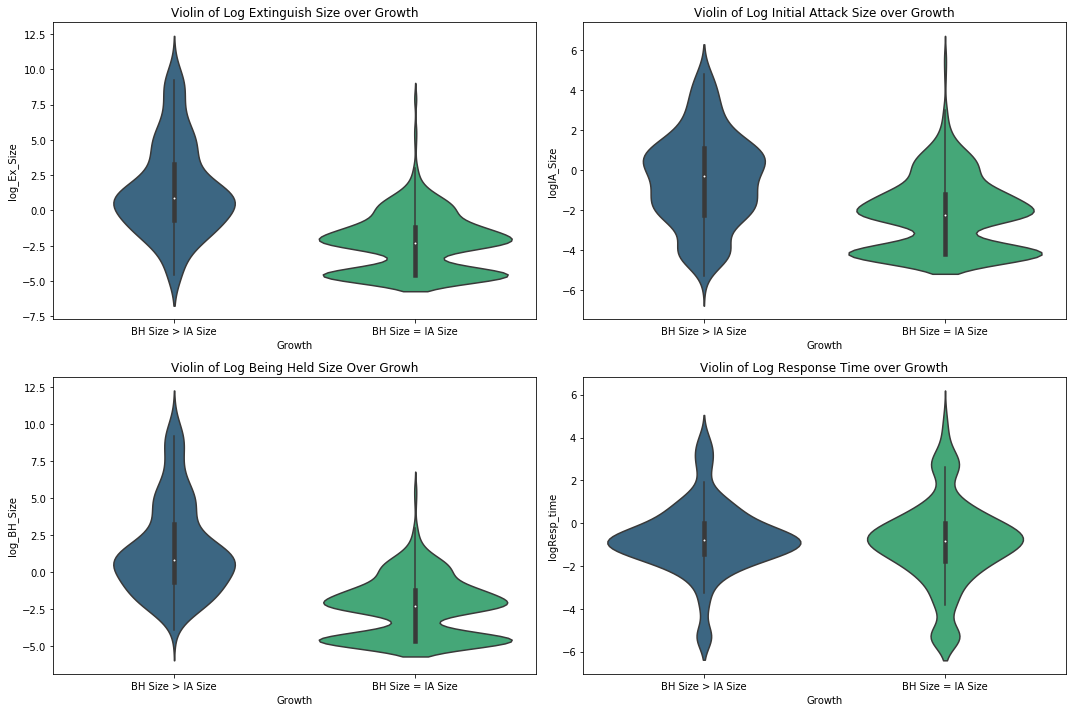

In [22]:
fig , ax = plt.subplots(nrows= 2, ncols = 2 ,figsize = (15,10))
fire['log_Ex_Size'] = np.log(fire['Ex_Size'])
fire['log_BH_Size'] = np.log(fire['BH_Size'])
fire['Growth_Plot'] = fire['Growth'].apply(lambda x: 'BH Size = IA Size' if x == 1 else 'BH Size > IA Size')

ax[0,0].set_title('Violin of Log Extinguish Size over Growth')
v_plot = sns.violinplot(x='Growth_Plot',y='log_Ex_Size' ,data =fire, palette ="viridis" ,ax =ax[0,0])
ax[0,0].set(xlabel='Growth')

ax[0,1].set_title('Violin of Log Initial Attack Size over Growth')
v_plot = sns.violinplot(x='Growth_Plot',y='logIA_Size' ,data =fire, palette ="viridis" ,ax =ax[0,1])
ax[0,1].set(xlabel='Growth')



ax[1,0].set_title('Violin of Log Being Held Size Over Growh')
v_plot = sns.violinplot(x='Growth_Plot',y='log_BH_Size',data =fire, palette ="viridis" ,ax =ax[1,0])
ax[1,0].set(xlabel='Growth')

ax[1,1].set_title('Violin of Log Response Time over Growth')
v_plot = sns.violinplot(x='Growth_Plot',y='logResp_time' ,data =fire, palette ="viridis" ,ax =ax[1,1])
ax[1,1].set(xlabel='Growth')





plt.tight_layout()

From the violin plots we see that the distribution of the 3 fire size variables looks noticeably different between the growth
observations and the no growth observations. However, I will not be using the Extinguish size or the Being Held size as
predictors in the models because they will be perfectly correlated with the response variable by its definition i.e. growth.


The distribution of response times looks similar between the two groups. Therefore, I do not expect there to be much signal
provided from the response time variable.

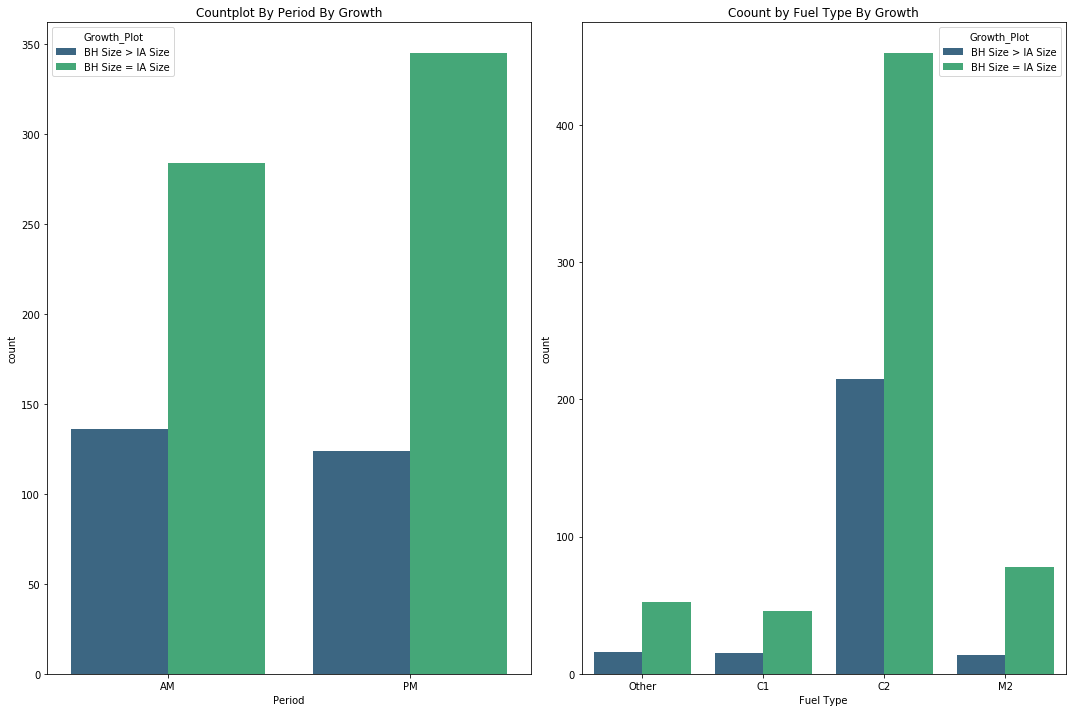

In [21]:
fig , ax = plt.subplots(nrows= 1, ncols = 2 ,figsize = (15,10))

ax[0].set_title('Countplot By Period By Growth')
v_plot = sns.countplot(x = 'Period', hue='Growth_Plot',data =fire, palette ="viridis" ,ax =ax[0])
ax[0].set(xlabel='Period')


ax[1].set_title('Coount by Fuel Type By Growth')
v_plot = sns.countplot(x = 'Fuel_type', hue='Growth_Plot',data =fire, palette ="viridis" ,ax =ax[1])
ax[1].set(xlabel='Fuel Type')


plt.tight_layout()


Looking at the count plots between b the categorical features Period and Fuel type the proportion of fires that result in
growth look to be similar across all levels with the exception of the Fuel Type of C2. Upon visual inspection the C2 fuel type
looks to have a higher proportion of growth. This suggests that levels of fuel type might provide some additional signal for
the models to determine growth versus no growth.

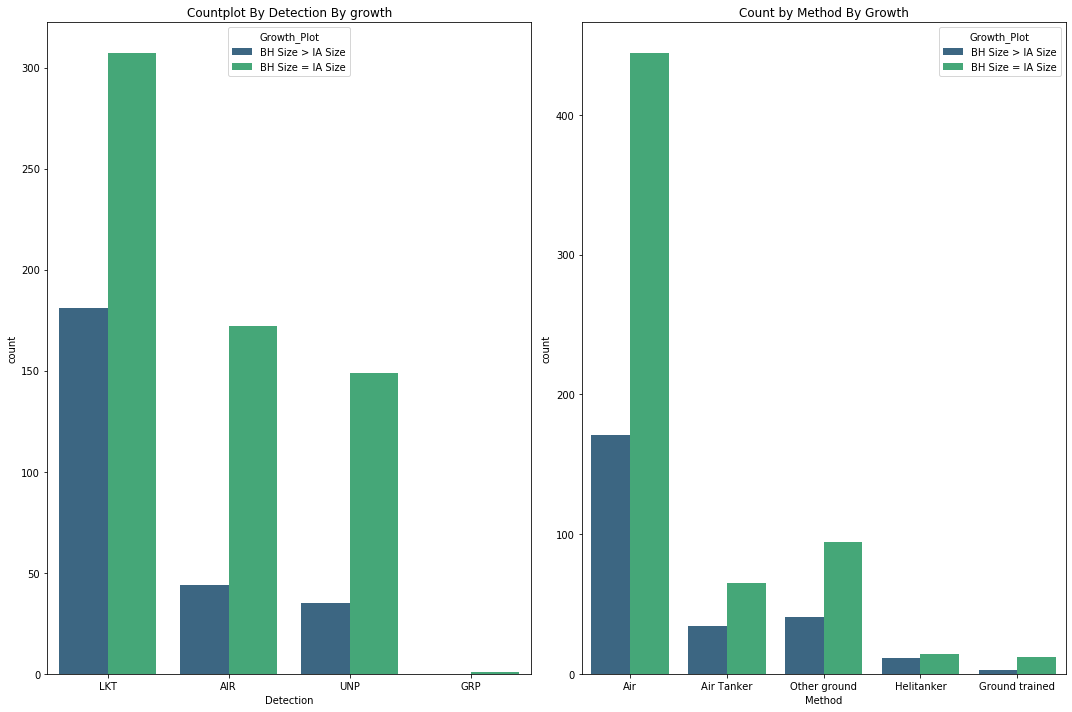

In [20]:
fig , ax = plt.subplots(nrows= 1, ncols = 2 ,figsize = (15,10))

ax[0].set_title('Countplot By Detection By growth')
v_plot = sns.countplot(x = 'Detection', hue='Growth_Plot',data =fire, palette ="viridis" ,ax =ax[0])
ax[0].set(xlabel='Detection')


ax[1].set_title('Count by Method By Growth')
v_plot = sns.countplot(x = 'Method', hue='Growth_Plot',data =fire, palette ="viridis" ,ax =ax[1])
ax[1].set(xlabel='Method')



plt.tight_layout()

When looking at the count plots for detection and method there is nothing visually that would suggest certain levels of these
factors will provide much predictive power in the models. Although the Helitanker Method appears to be roughly even when
broken out over growth and no growth, there are only a few examples of this method.

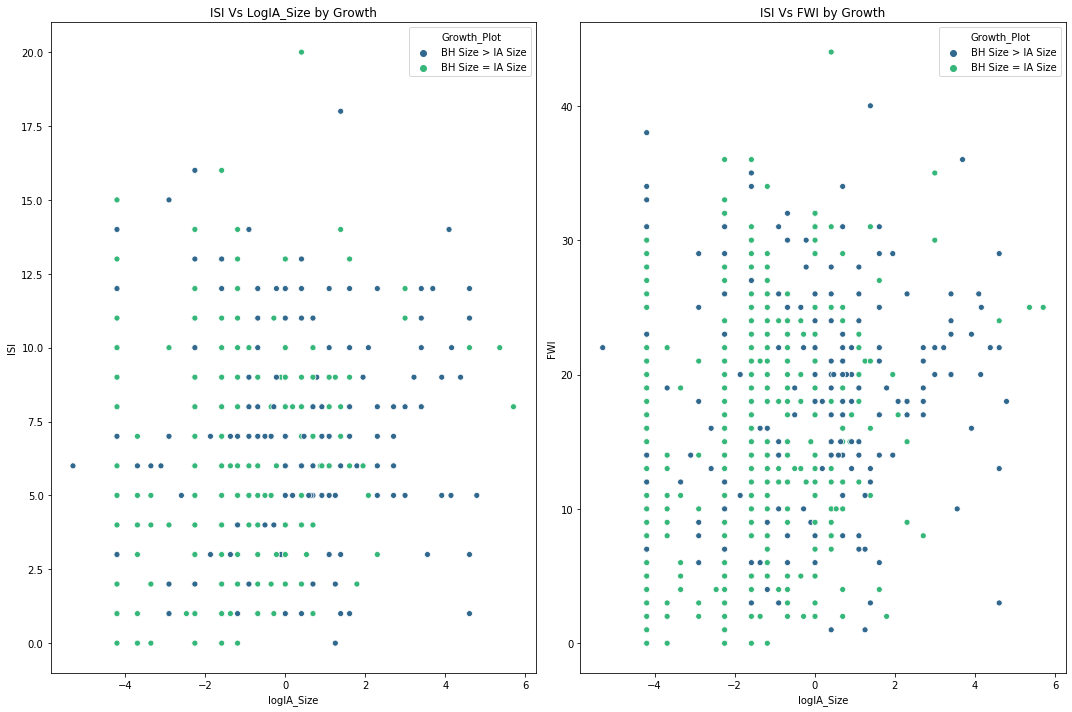

In [19]:
fig , ax = plt.subplots(nrows= 1, ncols = 2 ,figsize = (15,10))
sns.scatterplot(x='logIA_Size', y='ISI',hue ='Growth_Plot',data=fire,ax=ax[0], palette ="viridis")
ax[0].set_title('ISI Vs LogIA_Size by Growth')


sns.scatterplot(x='logIA_Size', y='FWI',hue ='Growth_Plot',data=fire,ax=ax[1], palette ="viridis")
ax[1].set_title('ISI Vs FWI by Growth')
plt.tight_layout()

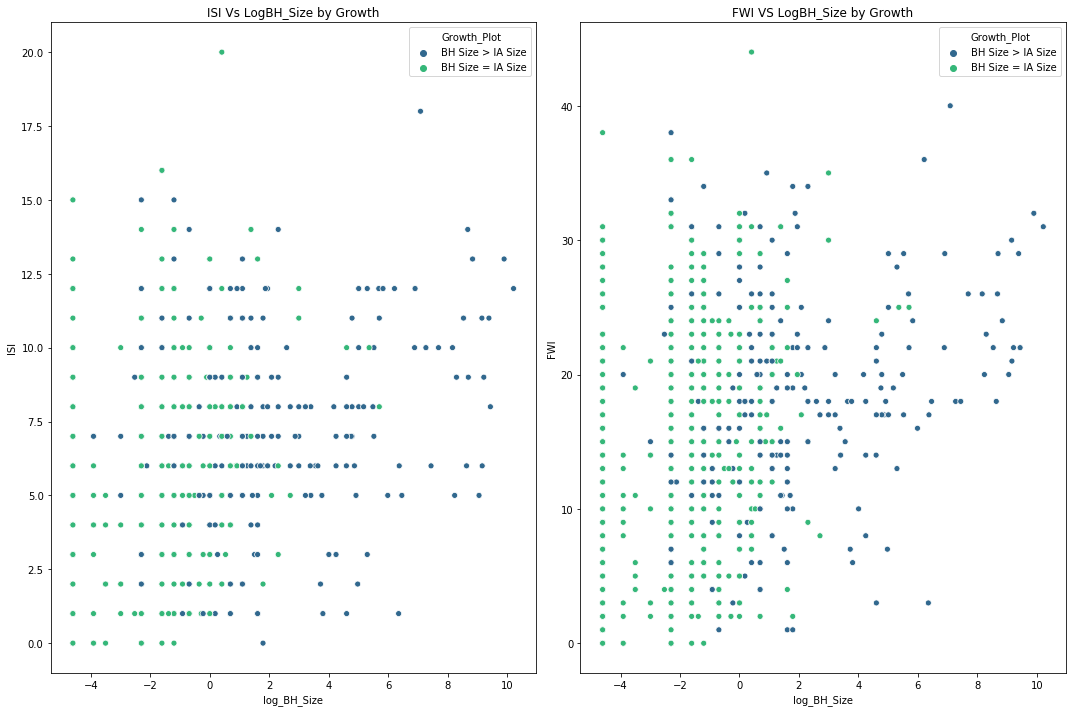

In [24]:
fig , ax = plt.subplots(nrows= 1, ncols = 2 ,figsize = (15,10))
sns.scatterplot(x='log_BH_Size', y='ISI',hue ='Growth_Plot',data=fire,ax=ax[0], palette ="viridis")
ax[0].set_title('ISI Vs LogBH_Size by Growth')


sns.scatterplot(x='log_BH_Size', y='FWI',hue ='Growth_Plot',data=fire,ax=ax[1], palette ="viridis")
ax[1].set_title('FWI VS LogBH_Size by Growth')

plt.tight_layout()

From the scatterplots we do see a positive correlation between the Fire Weather Index (FWI) and the size of the fire at Initial
Attack and at the Being Held stage. This suggests that the FWI predictor will be helpful for the models to make accurate
predictions.

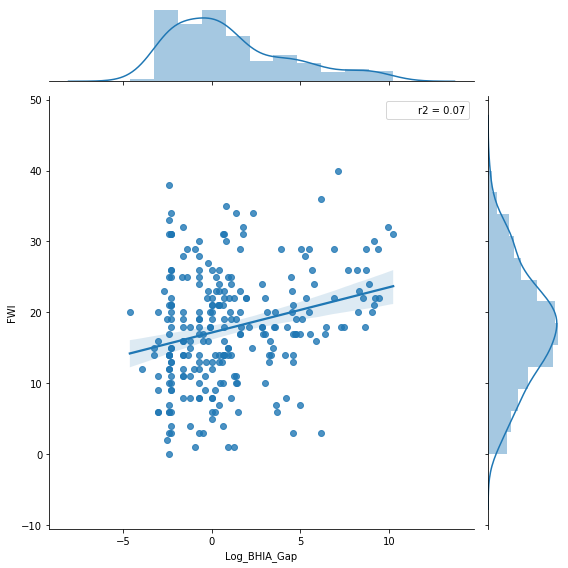

In [17]:
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


growth = fire[fire['Growth']==0].reset_index(drop=True)
growth['Log_BHIA_Gap'] =np.log(growth['BH_Size'] - growth['IA_Size'])


from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0]**2 

x,y = growth['Log_BHIA_Gap'] ,growth['FWI']


sns.jointplot(x, y, kind="reg", stat_func=r2 ,height= 8 )


plt.tight_layout()


Above we see the relationship between FWI and the log of the growth in size for all observations that experienced growth.
We see an r squared of 0.07 which means there is a correlation coeffecient of 0.26 between FWI and Log fire growth.

In [25]:
#### Create data for models not logit
cat_cols = ['Period','Fuel_type', 'Detection','Method']
dummy_code = pd.get_dummies(fire[cat_cols],drop_first = False)
data1 = pd.concat([fire, dummy_code] ,axis=1)
drop_cols = ['NUMBER','number_of_fire','IA_Size','BH_Size','Status','Gap_BHIA','Response_time','Month','Gap_UCIA',
            'Ex_Size', 'Gap','sqlogIA_Size','sqlogResp_time','sqFWI','sqISI','logNumber_of_fire','log_Ex_Size', 'log_BH_Size',
             'Growth_Plot' ] + cat_cols
data1.drop(drop_cols,axis= 1 , inplace=True)

nums = data1[['FWI','ISI','logIA_Size','logResp_time']]

data1[['FWI','ISI','logIA_Size','logResp_time']] = (nums-nums.mean())/nums.std()
data1.shape

(889, 20)

In [26]:
#Create data for logit model
cat_cols = ['Period','Fuel_type', 'Detection','Method']
dummy_code = pd.get_dummies(fire[cat_cols],drop_first = True)
data2 = pd.concat([fire, dummy_code] ,axis=1)
drop_cols = ['NUMBER','number_of_fire','IA_Size','BH_Size','Status','Gap_BHIA','Response_time','Month','Gap_UCIA',
            'Ex_Size', 'Gap','sqlogIA_Size','sqlogResp_time','sqFWI','sqISI','logNumber_of_fire','log_Ex_Size', 'log_BH_Size',
             'Growth_Plot' ] + cat_cols
data2.drop(drop_cols,axis= 1 , inplace=True)

nums = data2[['FWI','ISI','logIA_Size','logResp_time']]

data2[['FWI','ISI','logIA_Size','logResp_time']] = (nums-nums.mean())/nums.std()

data2.shape



(889, 16)

In [14]:
### Grid Search on SVM
from sklearn.model_selection import  train_test_split ,GridSearchCV
X=data1.drop('Growth',axis =1 )
Y= data1['Growth']


param_grid = {'C':[0.1,1,10,.001] ,'gamma':[10,1,0.1,0.01,.0001] ,'kernel':['sigmoid','rbf']}
from sklearn.svm import SVC
grid = GridSearchCV(SVC(),param_grid,verbose=0)
grid.fit(X,Y)
grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

I ran this gridsearch multiple times. For some, the output suggested the sigmoid kernel would work best and for some the
radial basis function worked best. I will therefore compare both of these in the Kfold-CV.

In [26]:
### Grid Search on RF
from sklearn.ensemble import RandomForestClassifier


param_grid = {'n_estimators':[1,50,75,100] ,'max_depth':[5,10,15] }

grid = GridSearchCV(RandomForestClassifier(),param_grid,verbose=0)
grid.fit(X,Y)
grid.best_params_

{'max_depth': 5, 'n_estimators': 50}

We can see that forests with max depth of 5 splits and 100 aggregated trees performed best in the gridsearch.

In [28]:
#### Grid Search KNN 
from sklearn.neighbors import  KNeighborsClassifier
param_grid = {'n_neighbors':list(range(40)) }

grid = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=0)
grid.fit(X,Y)
grid.best_params_

{'n_neighbors': 26}

In the following code I create two functions to use in a custom K-foldCV class I build to easily analyze binary classification.
In the first function I build a machinery to calculate the true positive, false positive, false negative and misclassification rate between two vectors. In practice this will be the test response and predicted response variables. In the second function I
recreate the 'rep' function found in R.

In [31]:
def MOFIT_CLASS(y_test, Prediction):
    d ={}
    y_test.reset_index(drop=True,inplace =True)
    Prediction.reset_index(drop=True,inplace =True)
    for val in np.unique(y_test):
        true_pos = sum(((y_test == val) & (Prediction == val)))
        false_pos = sum(((y_test != val) & (Prediction== val)))
        false_neg = sum(((y_test == val) & (Prediction != val)))
        mc_rate = sum(Prediction != y_test) / len(y_test)

        if ((true_pos + false_pos) > 0) :
            Precision = true_pos/(true_pos+false_pos)
        else:
            Precision = float('NaN')
        if ((true_pos + false_neg) > 0):
            Recall = true_pos/(true_pos+false_neg)
        else:
            Recall = float('NaN')
        if (np.isnan(Precision) or np.isnan(Recall) or (Precision+Recall) <=0):
            F1 = float('Nan')
        else:
            try:
                F1= 2*float((Precision*Recall))/float((Precision+Recall))
            except:print(f"Precision : {Precision} Recall: {Recall}")


        mofs = {'MisClass': mc_rate , 'Precision':Precision,'Recall':Recall,
                'F1':F1,'Confusion Matrix':confusion_matrix(y_test,Prediction)}
        d[str(val)] = mofs
    return d

def rep(pattern , n):
    elist = []
    if isinstance(pattern , float) or isinstance(pattern,int):
        elist = [pattern for x in range(n)]
        return elist
    else:
        if type(pattern) == str:
            elist = [pattern for x in range(n)]
            return elist
        else:
            elist = [pattern for x in range(n)]
            elist = sum(elist,[])
            return elist
from sklearn.metrics import classification_report,confusion_matrix


In the next chunk of code, I build a Kfold CV tool for running a Kfold Cross Validation for a classifier and outputting
performance metrics. The first method takes in a seed (in order for apples to apples comparisons between models). The
second method takes in a factor level and a model performance measure and plots them across all k folds for the model.
The next method takes in a factor level and a model performance metric and returns the average and standard deviation
across all k folds. Finally, returns the sum of the confusion matrices across all folds.

In [32]:
class Kfold_CV_Classifier():
    def __init__(self,k,model,data,response,name):
        self.k = k
        self.model = model
        self.data = data
        self.response = response
        self.met_list = []
        self.name = name


    def run_CV(self,seed = -28):
        nums = rep(list(range(self.k)), int(np.ceil(self.data.shape[0] / self.k)))

        if seed > 0:
            random.seed(seed)

        self.data['index'] = random.sample(nums, self.data.shape[0])

        for i in range(self.k):
            X_test = self.data[self.data['index'] == i].drop([self.response, 'index'], axis=1)
            X_train = self.data[self.data['index'] != i].drop([self.response, 'index'], axis=1)

            Y_test = self.data[self.data['index'] == i][self.response]
            Y_train = self.data[self.data['index'] != i][self.response]

            self.model.fit(X_train, Y_train)
            prediction = pd.Series(self.model.predict(X_test))

            self.met_list.append(MOFIT_CLASS(Y_test,prediction))

    def plot_metric(self,Category , Metric):
        metric_list =[]
        ks = []
        for val in range(self.k):
            if not np.isnan(self.met_list[val][Category][Metric]):
                metric_list.append(self.met_list[val][Category][Metric])
                ks.append(val)
            else:
                pass
        plt.figure(figsize=(10, 6))
        plt.plot(ks, metric_list, color='green', linestyle='dashed', marker='o',
                 markerfacecolor='red', markersize=10)
        plt.title(f"{Metric} vs. K Value")
        plt.xlabel('K')
        plt.ylabel(Metric)
        plt.title(self.name)
        plt.show()


    def mean_mofit(self,Category, Metric):
        mean_list=[]
        for val in range(self.k):
            if not np.isnan(self.met_list[val][Category][Metric]):
                mean_list.append(self.met_list[val][Category][Metric])
            else:
                pass
        mean_val = np.mean(mean_list)
        std_val = np.std(mean_list)
        print(f"Category: {Category}\nMetric: {Metric}\nValue: {mean_val}\nStd:{std_val}")

    def Sum_Confusion(self,Category):
        matrix_list = []
        for val in range(self.k):
            matrix_list.append(self.met_list[val][Category]['Confusion Matrix'])

        return sum(matrix_list)



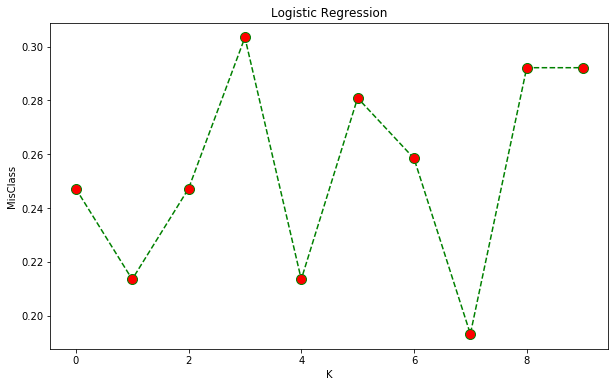

Category: 0
Metric: MisClass
Value: 0.2541496424923391
Std:0.036281862902582035


array([[ 93, 167],
       [ 59, 570]], dtype=int64)

In [85]:
#run Kfold_Class with Logistic Regression
from sklearn.linear_model import LogisticRegression
glm = LogisticRegression(solver ='newton-cg',penalty = 'none')

KF_glm = Kfold_CV_Classifier(k=10,model=glm,data=data2,response='Growth',name='Logistic Regression')
KF_glm.run_CV(seed=28)

KF_glm.plot_metric('0','MisClass')
KF_glm.mean_mofit('0','MisClass')
KF_glm.Sum_Confusion('0')

Since this analysis is looking at whether or not fire growth will occur, I decided that recall would be an additional informative metric to analyze. Choosing a model that maximizes Recall will ultimately allow for more false positives, and minimize false negatives. Given the subject matter of the data I decided this is a worthwhile tradeoff.

Recall is defined as follows

$$
\begin{aligned}
&Recall = \frac{TruePositive}{TruePositive \ + \ FalseNegative}
\end{aligned}
$$

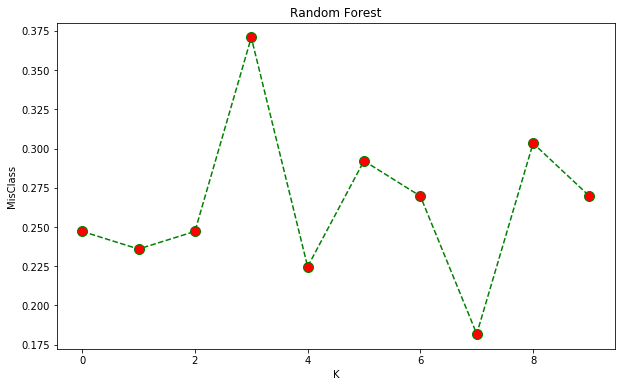

Category: 0
Metric: MisClass
Value: 0.26424923391215527
Std:0.04843237271873333


array([[ 70, 190],
       [ 45, 584]], dtype=int64)

In [34]:
#run Kfold_Class with Logistic Regression
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators= 50 ,max_depth=5)

KF_RF = Kfold_CV_Classifier(k=10,model=RF,data=data1,response='Growth',name='Random Forest')
KF_RF.run_CV(seed=28)

KF_RF.plot_metric('0','MisClass')
KF_RF.mean_mofit('0','MisClass')
KF_RF.Sum_Confusion('0')

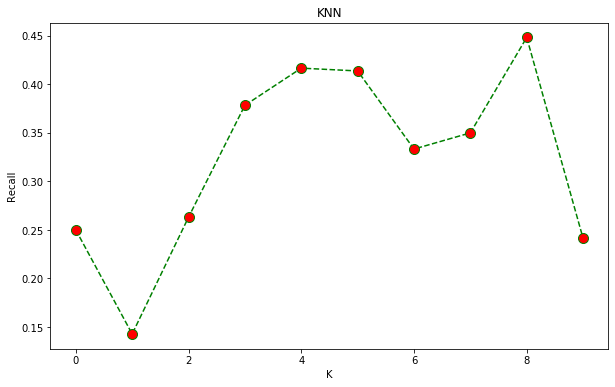

Category: 0
Metric: Recall
Value: 0.3237841691834432
Std:0.09199496213030088


array([[ 86, 174],
       [ 58, 571]], dtype=int64)

In [35]:
#run Kfold_Class with Logistic Regression
from sklearn.neighbors import  KNeighborsClassifier
KNN =KNeighborsClassifier(11)

KF_KNN = Kfold_CV_Classifier(k=10,model=KNN,data=data1,response='Growth',name='KNN')
KF_KNN.run_CV(seed=28)

KF_KNN.plot_metric('0','Recall')
KF_KNN.mean_mofit('0','Recall')
KF_KNN.Sum_Confusion('0')

Using the Kfold-CV tool I ran an analysis using Misclassification rate and Recall as measures of model fit. For the Logistic
Regression model, the Misclassification rate was on average 0.26 with a stanard deviation of 0.048 The Recall was on
average 0.32 with a standard deviation of 0.09.

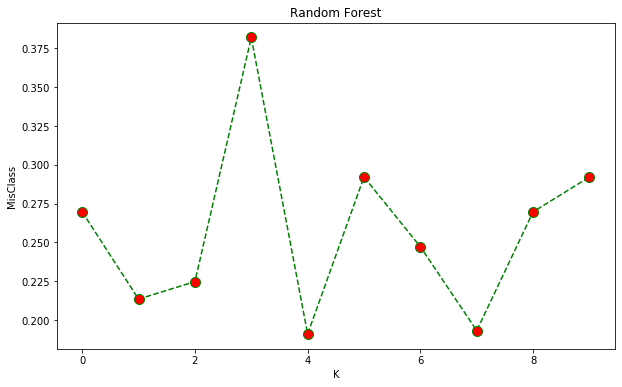

Category: 0
Metric: MisClass
Value: 0.257520429009193
Std:0.05465966384497381


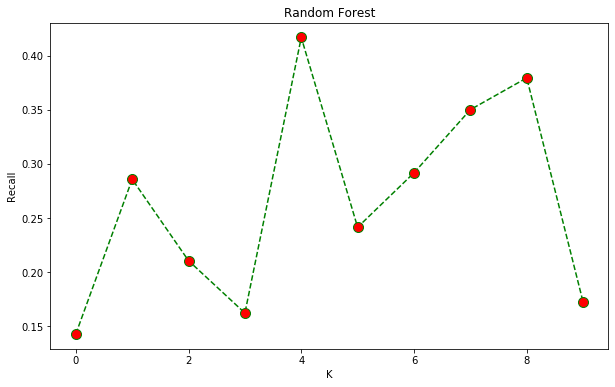

Category: 0
Metric: Recall
Value: 0.265269668813226
Std:0.09056827349816401


array([[ 67, 193],
       [ 36, 593]], dtype=int64)

In [38]:
#run Kfold_Class with Random Forest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators= 50 ,max_depth=5)
KF_RF = Kfold_CV_Classifier(k=10,model=RF,data=data1,response='Growth',name='Random Forest')
KF_RF.run_CV(seed=28)
KF_RF.plot_metric('0','MisClass')
KF_RF.mean_mofit('0','MisClass')
KF_RF.plot_metric('0','Recall')
KF_RF.mean_mofit('0','Recall')
KF_RF.Sum_Confusion('0')

Using the Kfold-CV tool I ran an analysis using Misclassification rate and Recall as measures of model fit. For the Random
Forest model, the Misclassification rate was on average 0.26 with a stanard deviation of 0.05 The Recall was on average
0.26 with a standard deviation of 0.09.

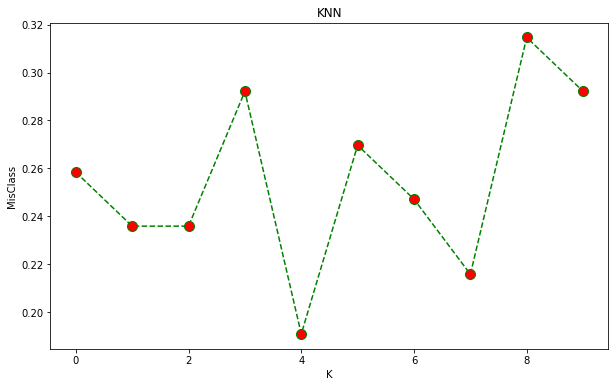

Category: 0
Metric: MisClass
Value: 0.2552987742594484
Std:0.03598036816005945


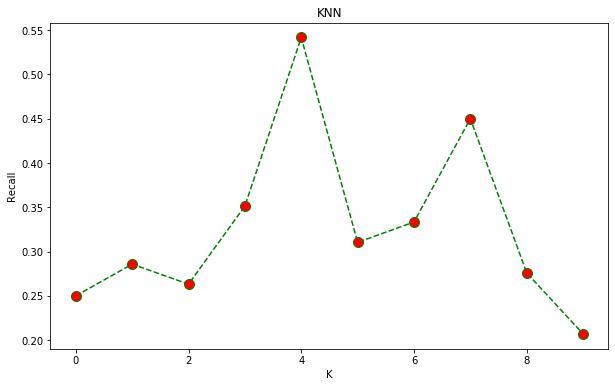

Category: 0
Metric: Recall
Value: 0.32683269800783415
Std:0.09532588470968793


array([[ 84, 176],
       [ 51, 578]], dtype=int64)

In [39]:
#run Kfold_Class with KNN
from sklearn.neighbors import KNeighborsClassifier
KNN =KNeighborsClassifier(26)
KF_KNN = Kfold_CV_Classifier(k=10,model=KNN,data=data1,response='Growth',name='KNN')
KF_KNN.run_CV(seed=28)
KF_KNN.plot_metric('0','MisClass')
KF_KNN.mean_mofit('0','MisClass')
KF_KNN.plot_metric('0','Recall')
KF_KNN.mean_mofit('0','Recall')
KF_KNN.Sum_Confusion('0')

Using the Kfold-CV tool I ran an analysis using Misclassification rate and Recall as measures of model fit. For the KNN
model, the Misclassification rate was on average 0.25 with a stanard deviation of 0.036. The Recall was on average 0.327
with a standard deviation of 0.095.

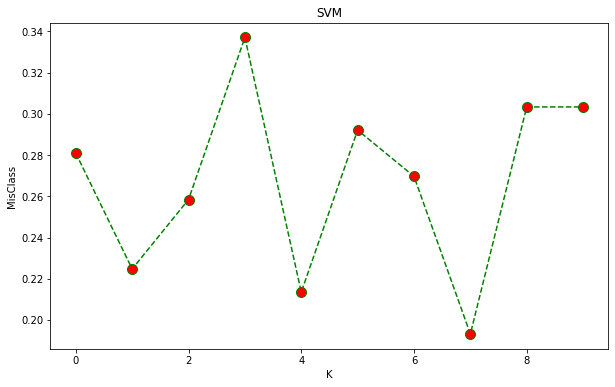

Category: 0
Metric: MisClass
Value: 0.26763278855975486
Std:0.04308022752800419


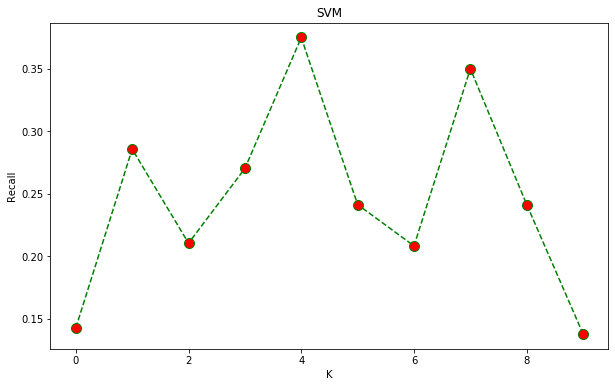

Category: 0
Metric: Recall
Value: 0.24633910031369194
Std:0.07393195013060573


array([[ 63, 197],
       [ 41, 588]], dtype=int64)

In [41]:
#Run KfolcClass for SVM
from sklearn.svm import SVC
SVM = SVC(C=1,gamma=0.1 , kernel='rbf')
SVM_KNN = Kfold_CV_Classifier(k=10,model=SVM,data=data1,response='Growth',name='SVM')
SVM_KNN.run_CV(seed=28)
SVM_KNN.plot_metric('0','MisClass')
SVM_KNN.mean_mofit('0','MisClass')
SVM_KNN.plot_metric('0','Recall')
SVM_KNN.mean_mofit('0','Recall')
SVM_KNN.Sum_Confusion('0')

Using the Kfold-CV tool I ran an analysis using Misclassification rate and Recall as measures of model fit. For theSVM with
a radial basid kernel , the Misclassification rate was on average 0.27 with a stanard deviation of 0.043. The Recall was on
average 0.24 with a standard deviation of 0.0739.

**Discussion of Analysis/Additional Model**


When looking at pure model accuracy all models did relatively similarly with the exception of using the Sigmoid kernel for
SVM. However, radial kernel SVM, Logistic Regression, Random Forest, and KNN all had an accuracy within a standard
deviation of each other so selecting a model based solely on accuracy is a toss up. The SVM using the sigmoid Kernel had
the highest recall score and if the goal is to make sure as many true positives then SVM with sigmoid kernel would be the
best.

I will now run one more model using the SVM, but I will increase the C value from 1 to 200. The C value is the error budget
we allow into our margins for an SVM. By increasing the margin we should get a more biased model, but that is accetpable
in this context since we are trying to maximize the rate at which we detect the true cases in which the fire will grow.

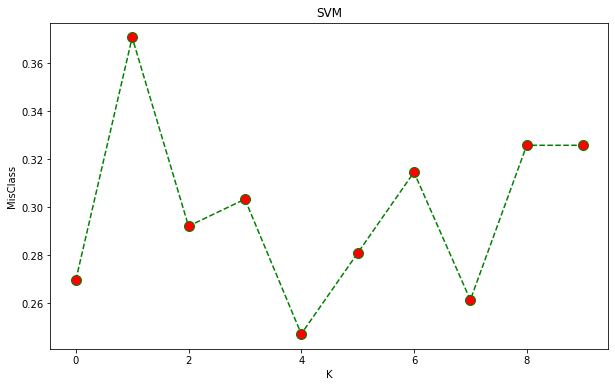

Category: 0
Metric: MisClass
Value: 0.2991700715015322
Std:0.03491827920109007


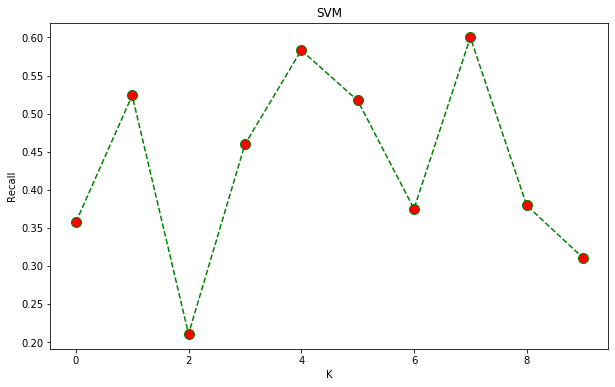

Category: 0
Metric: Recall
Value: 0.4316168041258786
Std:0.11960467301966168


array([[112, 148],
       [118, 511]], dtype=int64)

In [43]:
#Run KfolcClass for SVM
from sklearn.svm import SVC
SVM = SVC(C=200,gamma=0.1 , kernel='rbf')
SVM_KNN = Kfold_CV_Classifier(k=10,model=SVM,data=data1,response='Growth',name='SVM')
SVM_KNN.run_CV(seed=28)
SVM_KNN.plot_metric('0','MisClass')
SVM_KNN.mean_mofit('0','MisClass')
SVM_KNN.plot_metric('0','Recall')
SVM_KNN.mean_mofit('0','Recall')
SVM_KNN.Sum_Confusion('0')

Using the radial basis function and increasing our cost parameter to incorporate more bias in the model we now scored an
average recall 0.43 with a standard deviation of 0.12. This bias came at the cost of an increse to the misclassification rate
to .30 and a standard deviation of 0.035.

**Verdict**

In original model runs we saw all models perform equally well in terms of pure accuracy. Each model had an average
misclassification rate of roughly 0.25 and were all certainly with in the error of each other. However, if we take into account
Recall and decide the goal of our models should be to determine as many of the fires that will grow as possible then the
best model would be SVM with radial kernel and increased cost function that was run in the discussion of analysis section.
If the purpose was pure classification accuracy, I would say to use logistic regression since it had the best score point score
and was also what the authors of the paper found to be best for accuracy.

